## Setting up the environment and loading libraries

In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [ ]:
!pip install pypng

     |████████████████████████████████| 48 kB 3.3 MB/s 


In [ ]:
!pip install pydicom

In [13]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt

import pydicom
from pydicom.data import get_testdata_files
import pydicom.uid
import png
import argparse
import glob
import shutil

import pandas as pd
import seaborn as sns
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

## Data import and preprocessing

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
IMG_SIZE=(512,512)

### Contour and png style mask:

In [26]:
def cropper(path):
  '''Creates a .png stupe mask (0 in background 255 in the zone of interest)
  and plots the original image, the contour and the mask.'''
  img = cv2.imread(path)
  img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray = cv2.GaussianBlur(gray, (5, 5), 0)

  # threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  # find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])

  # add contour on the image
  img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

  # add extreme points
  img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
  img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
  img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
  img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

  # fill white

  contours = c
  frame = np.zeros( (512,512) ) # create a single channel 512x512 pixel black image 
  cv2.fillPoly(frame, pts =[contours], color=(255,255,255))

  #plot
  plt.figure(figsize=(15,6))
  plt.subplot(141)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.title('Step 1. Get the original image')
  plt.subplot(142)
  plt.imshow(img_cnt)
  plt.xticks([])
  plt.yticks([])
  plt.title('Step 2. Find the biggest contour')
  plt.subplot(143)
  plt.imshow(img_pnt)
  plt.xticks([])
  plt.yticks([])
  plt.title('Step 3. Find the extreme points')
  plt.subplot(144)
  plt.imshow(frame)
  plt.xticks([])
  plt.yticks([])
  plt.title('frame')
  plt.show()

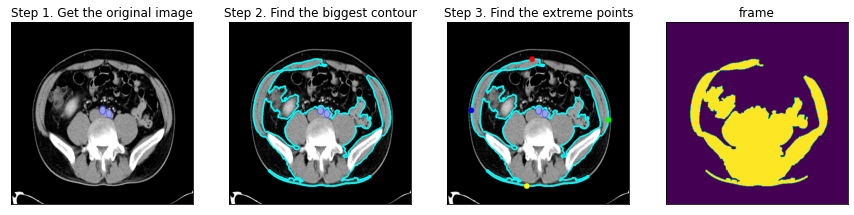

In [27]:
cropper('/content/ct_0002_aorta_3-1.png')

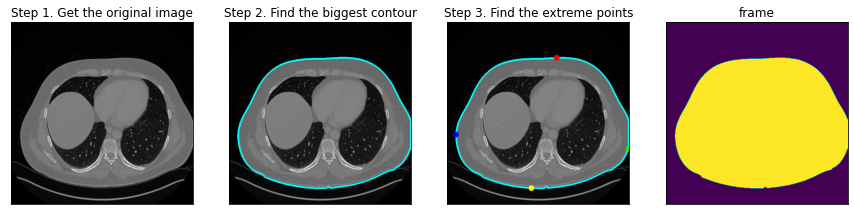

In [17]:
cropper('/content/ACT1.col.ccb4.fr.col.S2.3262583.1_00007.png')

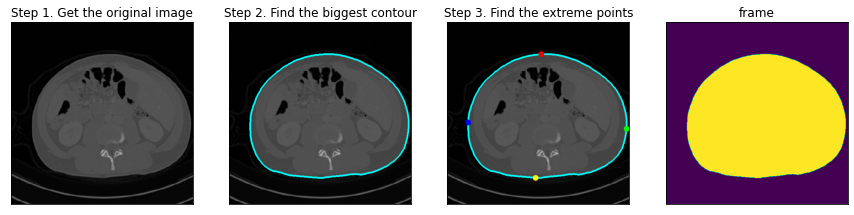

In [ ]:
cropper('/content/Screenshot from 2022-03-12 16-59-57.png')

In [47]:
def cropper_multiply(path):
  '''Creates a .png stupe mask (0 in background 255 in the zone of interest)
  and plots the original image, the contour and the mutiplication of image with mask.'''
  img = cv2.imread(path)
  img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray = cv2.GaussianBlur(gray, (5, 5), 0)

  # threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  # find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])

  # add contour on the image
  img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

  # add extreme points
  img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
  img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
  img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
  img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

  # fill white

  contours = c
  frame = np.zeros( (512,512,3) ) # create a single channel 512x512 pixel black image 
  cv2.fillPoly(frame, pts =[contours], color=(255,255,255))

  #plot
  plt.figure(figsize=(15,6))
  plt.subplot(141)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.title('Step 1. Get the original image')
  plt.subplot(142)
  plt.imshow(img_cnt)
  plt.xticks([])
  plt.yticks([])
  plt.title('Step 2. Find the biggest contour')
  plt.subplot(143)
  plt.imshow(img_pnt)
  plt.xticks([])
  plt.yticks([])
  plt.title('Step 3. Find the extreme points')
  plt.subplot(144)
  plt.imshow(frame*img_pnt)
  plt.xticks([])
  plt.yticks([])
  plt.title('frame')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


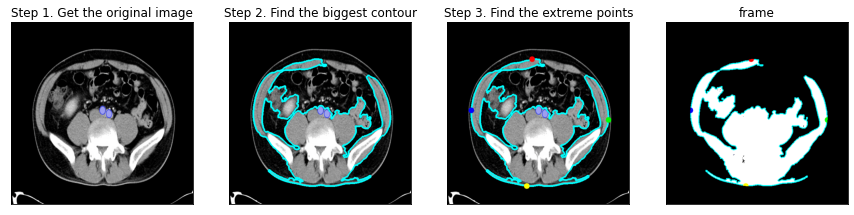

In [48]:
cropper_multiply('/content/ct_0002_aorta_3-1.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


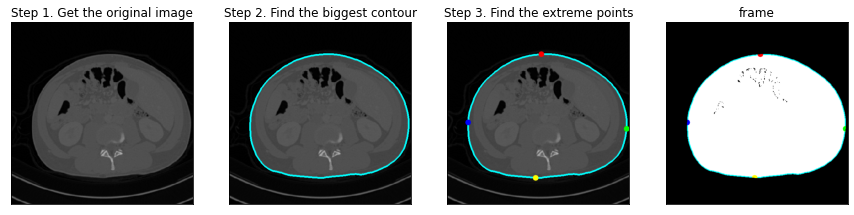

In [49]:
cropper_multiply('/content/Screenshot from 2022-03-12 16-59-57.png')

In [85]:
def dicom_compatible_cropper(path):
  img = cv2.imread(path)
  img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray = cv2.GaussianBlur(gray, (5, 5), 0)

  # threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  # find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])

  # add contour on the image
  img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

  # add extreme points
  img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
  img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
  img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
  img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

  # fill white

  contours = c
  mask = np.zeros(img_pnt.shape[:2], dtype=np.uint8)
  cv2.fillPoly(mask, pts =[contours], color=(1,1,1))

  masked = cv2.bitwise_and(img_pnt, img_pnt, mask=mask)

  #plot
  plt.imshow(masked)
  plt.xticks([])
  plt.yticks([])
  plt.title('frame')
  plt.show()

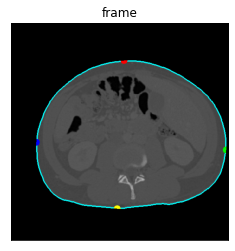

In [86]:
dicom_compatible_cropper('/content/Screenshot from 2022-03-12 16-59-57.png')

In [10]:
def convert_to_png(file):
    ds = pydicom.dcmread(file, force=True)
    ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian

    shape = ds.pixel_array.shape

    # Convert to float to avoid overflow or underflow losses.
    image_2d = ds.pixel_array.astype(float)

    # Rescaling grey scale between 0-255
    image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0

    # Convert to uint
    image_2d_scaled = np.uint8(image_2d_scaled)

    # Write the PNG file
    with open(f'{file.strip(".dcm")}.png', 'wb') as png_file:
        w = png.Writer(shape[1], shape[0], greyscale=True)
        w.write(png_file, image_2d_scaled)